In [38]:
import gsd.hoomd
import numpy as np
from cmeutils import gsd_utils
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.font_manager import FontProperties

In [63]:
gsd_file = gsd.hoomd.open("100_10mer10f_0.0005dt_7kT_large.gsd")
snap = gsd_file[65000]

In [64]:
delete_chains = gsd_utils.snap_delete_types(snap, 'A')
flakes = gsd_utils.get_molecule_cluster(snap=delete_chains)

def compute_flake_COMs_with_PBC(snap, flake_labels):
    box_Lx, box_Ly, box_Lz, *_ = snap.configuration.box
    typeid = snap.particles.typeid
    types = snap.particles.types
    type_F_id = types.index("F")
    is_F = (typeid == type_F_id)
    positions = snap.particles.position[is_F]
    image = snap.particles.image[is_F] 
    unwrapped_positions = positions + image * np.array([box_Lx, box_Ly, box_Lz])
    flake_ids = np.unique(flake_labels)
    coms = []
    for f in flake_ids:
        flake_pos = unwrapped_positions[flake_labels == f]
        com = flake_pos.mean(axis=0)
        com_wrapped = np.mod(com, [box_Lx, box_Ly, box_Lz])
        coms.append(com_wrapped)
    return np.array(coms), flake_ids

def find_neighbors(coms, flake_ids, cutoff):
    neighbors = {f: [] for f in flake_ids}
    for i, f in enumerate(flake_ids):
        for j, g in enumerate(flake_ids):
            if i != j and np.linalg.norm(coms[i] - coms[j]) <= cutoff:
                neighbors[f].append(g)
    return neighbors
    
def find_clusters(neighbors):
    visited = set()
    clusters = []

    def dfs(flake, cluster):
        visited.add(flake)
        cluster.append(flake)
        for neighbor in neighbors.get(flake, []):
            if neighbor not in visited:
                dfs(neighbor, cluster)

    for flake in neighbors.keys():
        if flake not in visited:
            cluster = []
            dfs(flake, cluster)
            clusters.append(cluster)
    return clusters

In [80]:
cutoff = 2.0
cluster_counts = []

for i in range(50001, len(gsd_file),100):
    snap = gsd_file[i]
    delete_chains = gsd_utils.snap_delete_types(snap, 'A')
    flakes = gsd_utils.get_molecule_cluster(snap=delete_chains)
    coms, flake_ids = compute_flake_COMs_with_PBC(snap, flakes)
    neighbors = find_neighbors(coms, flake_ids, cutoff)
    flake_clusters = find_clusters(neighbors)
    flake_clusters = [cluster for cluster in flake_clusters if len(cluster) > 1]
    cluster_counts.append(len(flake_clusters))

average_clusters = sum(cluster_counts) / len(cluster_counts)
print(f"Average number of clusters after timestep 50000: {average_clusters}")

Average number of clusters after timestep 50000: 1.06


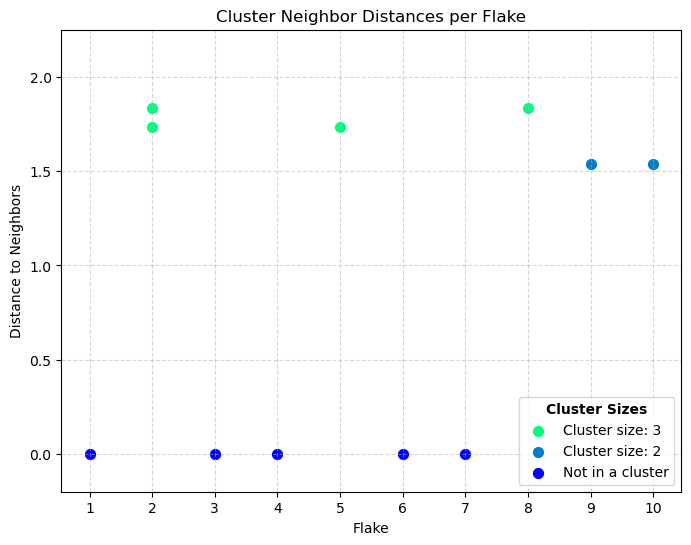

Flake cluster 0 (size=1): [0]
Flake cluster 1 (size=3): [1, 4, 7]
Flake cluster 2 (size=1): [2]
Flake cluster 3 (size=1): [3]
Flake cluster 4 (size=1): [5]
Flake cluster 5 (size=1): [6]
Flake cluster 6 (size=2): [8, 9]


In [81]:
coms, flake_ids = compute_flake_COMs_with_PBC(snap, flakes)
neighbors = find_neighbors(coms, flake_ids, cutoff)
flake_clusters = find_clusters(neighbors)
cluster_size_map = {flake: len(cluster) for cluster in flake_clusters for flake in cluster}
unique_sizes = sorted(set(cluster_size_map.values()), reverse=True)
cmap = plt.colormaps.get_cmap('winter')
norm = plt.Normalize(min(unique_sizes), max(unique_sizes))
size_color_map = {size: cmap(norm(size)) for size in unique_sizes}
size_label_map = {size: f"Cluster size: {size}" if size > 1 else "Not in a cluster" for size in unique_sizes}
plt.figure(figsize=(8,6))
plotted_labels = set()

for size in unique_sizes:
    color = size_color_map[size]
    label = size_label_map[size]
    flakes_of_size = [f for f, s in cluster_size_map.items() if s == size]
    for flake in flakes_of_size:
        pos1 = coms[flake_ids == flake][0]
        nbrs = neighbors.get(flake, [])
        distances = [np.linalg.norm(pos1 - coms[flake_ids == nbr][0]) for nbr in nbrs] or [0]
        x_vals = [flake + 1] * len(distances)
        if label not in plotted_labels:
            plt.scatter(x_vals, distances, s=50, color=color, label=label)
            plotted_labels.add(label)
        else:
            plt.scatter(x_vals, distances, s=50, color=color)

plt.xlabel("Flake")
plt.ylabel("Distance to Neighbors")
plt.title("Cluster Neighbor Distances per Flake")
plt.xticks(range(1, len(flake_ids) + 1))
plt.ylim(-0.2, cutoff + 0.25)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(title="Cluster Sizes", title_fontproperties=FontProperties(weight='bold'))
plt.show()

for i, cluster in enumerate(flake_clusters):
    print(f"Flake cluster {i} (size={len(cluster)}): {sorted(cluster)}")

In [82]:
from cmeutils import sampling

data = np.genfromtxt("100_10mer10f_0.0005dt_7kT_large.txt", names=True, dtype=None)
potential_energy = data['mdcomputeThermodynamicQuantitiespotential_energy'][50000:]

uncorr_sample, uncorr_indices, prod_start, Neff = sampling.equil_sample(potential_energy)

print(f"Equilibrated samples starting from timestep {prod_start}")
print(f"Number of effectively independent samples: {Neff}")
print(f"Decorrelation inefficiency (g): {Neff / len(uncorr_sample)}")
print(f"Statistically independent samples: {uncorr_sample}")

Equilibrated samples starting from timestep 7
Number of effectively independent samples: 9616.3994140625
Decorrelation inefficiency (g): 1.2826996684090304
Statistically independent samples: [10446.6 11147.8 11115.2 ... 10464.1 11419.2 10833. ]
